In [1]:
import string
import pickle

import numpy as np 
import pandas as pd 

import gensim
import gensim.downloader as api
import nltk
from nltk.stem import WordNetLemmatizer 


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Embedding
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences

2022-12-13 17:21:51.984297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
fname = 'FinancialPhraseBank-v1.0/Sentences_AllAgree.txt'

df = pd.read_csv(fname, sep="@", encoding='latin1', header=None)
print('There are {} sentences in this dataset'.format(len(df)))

There are 2264 sentences in this dataset


### Preprocess the dataframe 

- Convert to lowercase
- Remove punctuations
- Apply Lemmatization

In [3]:
def preprocess(df):
    # Remove lowercase, punctuations, lemmatize
    lemmatizer = WordNetLemmatizer()
    
    df['lcase'] = df[0].apply(lambda x: x.lower())
    df['no_punct'] = df['lcase'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    df['cleaned'] = df['no_punct'].apply(lambda x: ' '.join(lemmatizer.lemmatize(t) for t in x.split()))
    
preprocess(df)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned'], df[1], test_size=0.1, stratify=df[1], random_state=13)

print("Training set length - {}, Test set length - {}".format(len(X_train), len(X_test)))

Training set length - 2037, Test set length - 227


### Represent words in the sentences using tf-idf

In [5]:
tfidf = TfidfVectorizer()

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

### Model 1 - Multinomial Naive Bayes' Classifier using tf-idf features

The laplacian smoothing coefficient is unchanged

In [6]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

MultinomialNB()

### Model 1 - Prediction and evaluation metrics

Accuracy of Naive Bayes' model - 77.974 %


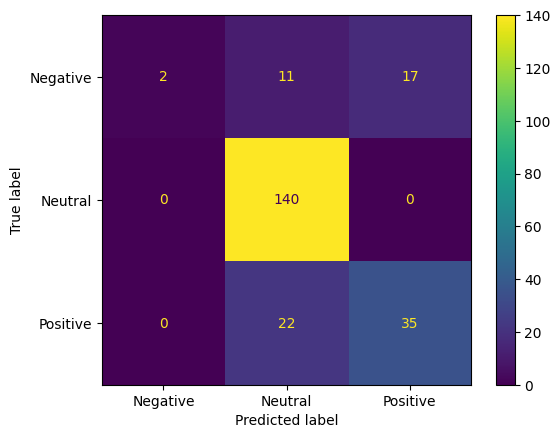

In [7]:
y_pred = nb.predict(X_test_tfidf)
acc_score = accuracy_score(y_test, y_pred)

print("Accuracy of Naive Bayes' model - %.3f"%(acc_score*100), "%")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot()

In [8]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

    negative       0.07      1.00      0.12         2
     neutral       1.00      0.81      0.89       173
    positive       0.61      0.67      0.64        52

    accuracy                           0.78       227
   macro avg       0.56      0.83      0.55       227
weighted avg       0.90      0.78      0.83       227



### Word2vec

In [9]:
wv = api.load('word2vec-google-news-300')

tokenized_sents = [[word for word in sent.split()] for sent in df['cleaned']]
max_length = max(len(arr) for arr in tokenized_sents)

### Tokenize the dataset 

The text sequences is padded to match with the length of the longest sentence.  

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_sents)

input_sents = tokenizer.texts_to_sequences(tokenized_sents)
input_sents = pad_sequences(input_sents, maxlen=max_length, padding='post')

### Create embeddings for words from word2vec dict

The length of the word embeddings is set to be 300.

Overall there are 6302 unique words in the dataset.

In [11]:
embeddings = np.zeros((len(tokenizer.word_index)+1, 300))
for w, i in tokenizer.word_index.items():
    if w in wv and i < embeddings.shape[0]:
        embeddings[i] = wv[w]
        
print(embeddings.shape)

(6302, 300)


### Convert categorical label into one-hot-encoding & data split

In [12]:
Y = pd.get_dummies(df[1]).values
X_train_1, X_valtest_1, y_train_1, y_valtest_1 = train_test_split(input_sents, Y, test_size=0.2, stratify=df[1], random_state=13)
X_val_1, X_test_1, y_val_1, y_test_1 = train_test_split(X_valtest_1, y_valtest_1, test_size=0.5, stratify=y_valtest_1, random_state=13)

print("Training set length - {} \nValidation set length - {} \nTest set length - {}".format(len(X_train_1), len(X_val_1), len(X_test_1)))


Training set length - 1811 
Validation set length - 226 
Test set length - 227


### Model 2 - LSTM using word2vec features

In [22]:
model = Sequential()

model.add(Embedding(embeddings.shape[0], 
                    embeddings.shape[1], 
                    weights = [embeddings],
                    input_length=52,
                    trainable = False))
model.add(LSTM(32, activation='relu', dropout=0.25,
               recurrent_dropout=0.25, return_sequences=True))
model.add(LSTM(16, activation='relu', dropout=0.25,
               recurrent_dropout=0.25, return_sequences=True))
model.add(LSTM(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model.summary()

2022-12-13 11:59:03.548819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 52, 300)           1890600   
                                                                 
 lstm (LSTM)                 (None, 52, 32)            42624     
                                                                 
 lstm_1 (LSTM)               (None, 52, 16)            3136      
                                                                 
 lstm_2 (LSTM)               (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 3)                 27        
                                                                 
Total params: 1,937,187
Trainable params: 46,587
Non-trainable params: 1,890,600
_________________________________________________________________


In [23]:
history = model.fit(X_train_1, 
                    y_train_1, 
                    validation_data=(X_val_1, y_val_1),
                    batch_size=4, 
                    epochs=100, 
                    verbose=1)

Epoch 1/100
453/453 [==============================] - 34s 63ms/step - loss: 1.0225 - accuracy: 0.6113 - val_loss: 0.9385 - val_accuracy: 0.6150
Epoch 2/100
453/453 [==============================] - 35s 77ms/step - loss: 0.9079 - accuracy: 0.6151 - val_loss: 0.8448 - val_accuracy: 0.6150
Epoch 3/100
453/453 [==============================] - 27s 59ms/step - loss: 0.8279 - accuracy: 0.6146 - val_loss: 0.8107 - val_accuracy: 0.6150
Epoch 4/100
453/453 [==============================] - 25s 56ms/step - loss: 0.8011 - accuracy: 0.6146 - val_loss: 0.7778 - val_accuracy: 0.6150
Epoch 5/100
453/453 [==============================] - 31s 69ms/step - loss: 0.7762 - accuracy: 0.6146 - val_loss: 0.7553 - val_accuracy: 0.6150
Epoch 6/100
453/453 [==============================] - 40s 88ms/step - loss: 0.7585 - accuracy: 0.6173 - val_loss: 0.7238 - val_accuracy: 0.6195
Epoch 7/100
453/453 [==============================] - 40s 89ms/step - loss: 0.7330 - accuracy: 0.6372 - val_loss: 0.6850 - val_ac

453/453 [==============================] - 32s 71ms/step - loss: 0.3526 - accuracy: 0.8332 - val_loss: 0.3741 - val_accuracy: 0.8186
Epoch 58/100
453/453 [==============================] - 33s 72ms/step - loss: 0.3570 - accuracy: 0.8327 - val_loss: 0.3767 - val_accuracy: 0.8274
Epoch 59/100
453/453 [==============================] - 32s 72ms/step - loss: 0.3426 - accuracy: 0.8327 - val_loss: 0.3619 - val_accuracy: 0.8363
Epoch 60/100
453/453 [==============================] - 34s 75ms/step - loss: 0.3420 - accuracy: 0.8371 - val_loss: 0.3623 - val_accuracy: 0.8230
Epoch 61/100
453/453 [==============================] - 41s 90ms/step - loss: 0.3471 - accuracy: 0.8310 - val_loss: 0.3514 - val_accuracy: 0.8363
Epoch 62/100
453/453 [==============================] - 43s 94ms/step - loss: 0.3312 - accuracy: 0.8377 - val_loss: 0.3746 - val_accuracy: 0.8274
Epoch 63/100
453/453 [==============================] - 40s 89ms/step - loss: 0.3331 - accuracy: 0.8338 - val_loss: 0.3513 - val_accuracy

In [39]:
test_accuracy = model.evaluate(X_test_1, y_test_1)
print("Accuracy of LSTM model - %.3f"%(test_accuracy[1]*100), "%")

8/8 [==============================] - 0s 20ms/step - loss: 0.5791 - accuracy: 0.8194
Accuracy of LSTM model - 81.938 %


8/8 [==============================] - 0s 17ms/step


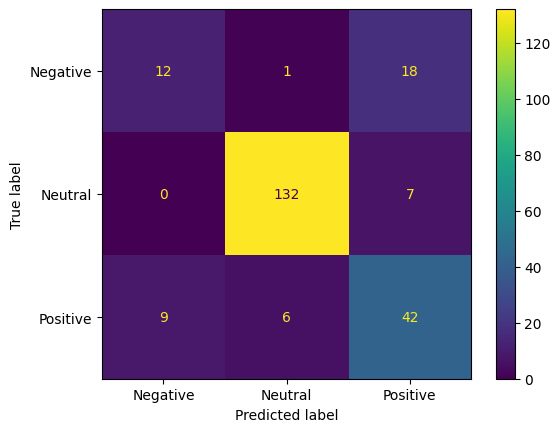

In [55]:
y_pred_1 = model.predict(X_test_1)
y_pred_1 = np.apply_along_axis(lambda x: np.argmax(x), axis=1, arr=y_pred_1)

y_test_class = np.apply_along_axis(lambda x: np.argmax(x), axis=1, arr=y_test_1)
cm = confusion_matrix(y_test_class, y_pred_1)
disp = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot()

In [56]:
print(classification_report(y_pred_1, y_test_class))

              precision    recall  f1-score   support

           0       0.39      0.57      0.46        21
           1       0.95      0.95      0.95       139
           2       0.74      0.63      0.68        67

    accuracy                           0.82       227
   macro avg       0.69      0.72      0.70       227
weighted avg       0.83      0.82      0.82       227



In [19]:
# model.save('model.keras')

In [23]:
# m1 = tf.keras.models.load_model('model.keras')
# ta = m1.evaluate(X_test_1[9:], y_test_1[9:])
# res = m1.predict(X_test_1[9:10])

In [33]:
# with open('tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f)

In [20]:
print('3')

3
